### Student Information
Name: 林宜蓁

Student ID: 110006261

GitHub ID: yjenlin

Kaggle name: Yi Jen L

Kaggle private scoreboard snapshot: 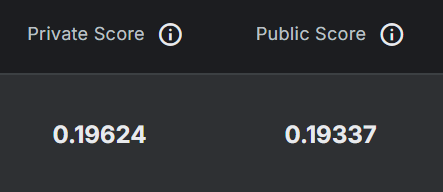

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook.


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking:
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission **BEFORE the deadline (Nov. 26th 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained.


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th 11:59 pm, Tuesday)__.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip3 install scikit-learn --upgrade
!pip3 install pandas --upgrade
!pip3 install numpy --upgrade
!pip3 install matplotlib --upgrade
!pip3 install plotly --upgrade
!pip3 install seaborn --upgrade
!pip3 install nltk --upgrade
!pip3 install umap-learn --upgrade

!pip3 install gensim --upgrade
#!pip3 install tensorflow --upgrade
!pip3 install tensorflow==2.17.0
!pip3 install keras --upgrade

!pip3 install ollama --upgrade
!pip3 install langchain --upgrade
!pip3 install langchain_community --upgrade
!pip3 install langchain_core --upgrade
!pip3 install beautifulsoup4 --upgrade
!pip3 install chromadb --upgrade
!pip3 install gradio --upgrade

  Using cached numpy-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.1.3 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.1.3 which is incompatible.
langchain 0.3.10 requires numpy<2,>=1.22.4; python_version < "3.12", but you have numpy 2.1.3 which is incompatible.
langchain-community 0.3.10 requires numpy<2,>=1.22.4; python_version < "3.

In [3]:
### Begin Assignment Here
# import library
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import umap
import gensim
import tensorflow
import keras
import langchain
import bs4

%matplotlib inline

print("gensim: " + gensim.__version__)
print("tensorflow: " + tensorflow.__version__)
print("keras: " + keras.__version__)

gensim: 4.3.3
tensorflow: 2.17.0
keras: 3.7.0


##1. Data Loading

1.1 Load Data

In [4]:
# Load tweets from JSON and normalize
tweets = pd.read_json("/content/drive/MyDrive/Colab_Notebooks/datamininglab2/tweets_DM.json", lines=True)
tweets_normalized = pd.json_normalize(tweets['_source'])
tweets_df = tweets_normalized[['tweet.tweet_id', 'tweet.text']].rename(
    columns={'tweet.tweet_id': 'tweet_id', 'tweet.text': 'text'}
)

# Load the CSV files
emotion_df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/datamininglab2/emotion.csv")
data_identification_df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/datamininglab2/data_identification.csv")


# Align emotion information using `map`
tweets_df['emotion'] = tweets_df['tweet_id'].map(
    emotion_df.set_index('tweet_id')['emotion']
)

# Align identification information using `map`
tweets_df['identification'] = tweets_df['tweet_id'].map(
    data_identification_df.set_index('tweet_id')['identification']
)

# Separate datasets for training/validation and testing
train_df = tweets_df[tweets_df['identification'] == 'train'].copy()
train_df.drop(columns=['identification', 'tweet_id'], inplace=True)

test_df = tweets_df[tweets_df['identification'] == 'test'].copy()
test_df.drop(columns=['identification'], inplace=True)

In [5]:
tweets_df

,tweet_id,text,emotion,identification
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",anticipation,train
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",sadness,train
2,0x28b412,"Confident of your obedience, I write to you, k...",NaN,test
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,fear,train
4,0x2de201,"""Trust is not the same as faith. A friend is s...",NaN,test
...,...,...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,NaN,test
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,NaN,test
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...,NaN,test
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us...",joy,train


In [6]:
emotion_df

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation
...,...,...
1455558,0x38dba0,joy
1455559,0x300ea2,joy
1455560,0x360b99,fear
1455561,0x22eecf,joy


In [7]:
data_identification_df

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train
...,...,...
1867530,0x227e25,train
1867531,0x293813,train
1867532,0x1e1a7e,train
1867533,0x2156a5,train


In [8]:
train_df

,text,emotion
0,"People who post ""add me on #Snapchat"" must be ...",anticipation
1,"@brianklaas As we see, Trump is dangerous to #...",sadness
3,Now ISSA is stalking Tasha 😂😂😂 <LH>,fear
5,@RISKshow @TheKevinAllison Thx for the BEST TI...,joy
6,Still waiting on those supplies Liscus. <LH>,anticipation
...,...,...
1867526,I'm SO HAPPY!!! #NoWonder the name of this sho...,joy
1867527,In every circumtance I'd like to be thankful t...,joy
1867528,there's currently two girls walking around the...,joy
1867533,"Ah, corporate life, where you can date <LH> us...",joy


In [9]:
test_df

,tweet_id,text,emotion
2,0x28b412,"Confident of your obedience, I write to you, k...",NaN
4,0x2de201,"""Trust is not the same as faith. A friend is s...",NaN
9,0x218443,When do you have enough ? When are you satisfi...,NaN
30,0x2939d5,"God woke you up, now chase the day #GodsPlan #...",NaN
33,0x26289a,"In these tough times, who do YOU turn to as yo...",NaN
...,...,...,...
1867525,0x2913b4,"""For this is the message that ye heard from th...",NaN
1867529,0x2a980e,"""There is a lad here, which hath five barley l...",NaN
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,NaN
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,NaN


1.2 Save and Load Data

In [10]:
## save to pickle file
train_df.to_pickle("train_df.pkl")
test_df.to_pickle("test_df.pkl")

In [11]:
## load a pickle file
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

1.3 Exploratory Data Analysis (EDA)

In [12]:
# group to find distribution
train_df.groupby(['emotion']).count()['text']

,text
emotion,
anger,39867
anticipation,248935
disgust,139101
fear,63999
joy,516017
sadness,193437
surprise,48729
trust,205478


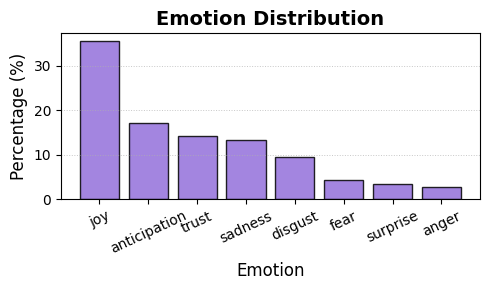

In [13]:
import matplotlib.pyplot as plt

def calculate_emotion_percentages(df):
    """Calculate emotion percentages based on the total number of instances."""
    total = len(df)
    emotion_counts = df['emotion'].value_counts()
    return (emotion_counts / total * 100).round(2)

def plot_distribution(percentages, title="Emotion Distribution", figsize=(5, 3)):
    """Plot the distribution of emotions."""
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(percentages.index, percentages.values, color='#9370DB', edgecolor='black', alpha=0.85)  # Using lavender color

    # Adding labels and title
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_xlabel("Emotion", fontsize=12)
    ax.set_ylabel("Percentage (%)", fontsize=12)

    # Adding grid for better visualization
    ax.grid(axis='y', linestyle=':', linewidth=0.7, alpha=0.7)
    plt.xticks(rotation=25, fontsize=10)
    plt.yticks(fontsize=10)

    # Show plot
    plt.tight_layout()
    plt.show()

# Example usage
emotion_percentages = calculate_emotion_percentages(train_df)
plot_distribution(emotion_percentages)


##2. Preprocessing

In [14]:
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import nltk

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
# Setup stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function for basic text cleaning and preprocessing
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphabetical characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Preprocess text using joblib for parallelization
def preprocess_text_parallel(texts):
    return Parallel(n_jobs=-1)(delayed(clean_text)(text) for text in texts)

# Preprocess datasets
preprocess_train_df = train_df.copy()
preprocess_test_df = test_df.copy()

# Apply preprocessing
preprocess_train_df['preprocessed'] = preprocess_text_parallel(preprocess_train_df['text'])
preprocess_test_df['preprocessed'] = preprocess_text_parallel(preprocess_test_df['text'])

# Save preprocessed data
preprocess_train_df.to_pickle("preprocess_train_df.pkl")
preprocess_test_df.to_pickle("preprocess_test_df.pkl")

# Function to calculate top terms using CountVectorizer
def show_top_terms_with_counts(text, top_n=100):
    # Initialize CountVectorizer
    vectorizer = CountVectorizer(max_features=top_n)
    count_matrix = vectorizer.fit_transform(text)
    terms = vectorizer.get_feature_names_out()
    counts = count_matrix.sum(axis=0).A1

    # Sort terms and counts in descending order
    sorted_indices = counts.argsort()[::-1][:top_n]
    top_terms = terms[sorted_indices]
    top_counts = counts[sorted_indices]

    # Print terms and counts as arrays
    print("Top 100 Terms:\n", list(top_terms))
    print("\nCorresponding Counts:\n", list(top_counts))

    # Create DataFrame for visualization
    term_data = pd.DataFrame({'term': top_terms, 'count': top_counts})

# Example: Visualize and print top terms and their counts
show_top_terms_with_counts(preprocess_train_df['preprocessed'])

Top 100 Terms:
 ['lh', 'love', 'life', 'im', 'day', 'today', 'like', 'god', 'get', 'one', 'dont', 'time', 'good', 'people', 'make', 'know', 'go', 'cant', 'see', 'never', 'got', 'thank', 'pip', 'thing', 'new', 'need', 'come', 'work', 'want', 'great', 'happy', 'realdonaldtrump', 'much', 'back', 'still', 'year', 'say', 'thanks', 'lot', 'going', 'always', 'give', 'way', 'let', 'really', 'best', 'feel', 'week', 'right', 'dream', 'world', 'think', 'even', 'would', 'youre', 'last', 'please', 'first', 'friend', 'look', 'moment', 'hope', 'another', 'man', 'night', 'take', 'total', 'morning', 'pm', 'ever', 'every', 'closed', 'keep', 'someone', 'blessed', 'feeling', 'better', 'show', 'follow', 'well', 'ive', 'eurusd', 'amazing', 'thats', 'help', 'tonight', 'play', 'guy', 'family', 'made', 'everyone', 'many', 'everything', 'believe', 'home', 'game', 'girl', 'jesus', 'wait', 'nothing']

Corresponding Counts:
 [1862331, 87057, 83322, 79408, 76495, 68455, 59578, 58478, 54862, 53066, 50183, 49690, 469

##3. Model

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Load and preprocess data
texts = preprocess_train_df['preprocessed'].values
labels = preprocess_train_df['emotion'].values

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Create label mappings
label_to_index = {label: index for index, label in enumerate(label_encoder.classes_)}
index_to_label = {index: label for label, index in label_to_index.items()}

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(
    texts, encoded_labels, stratify=encoded_labels, test_size=0.2, random_state=42
)

X_test = preprocess_test_df['preprocessed'].values


In [17]:
# Step 2: Tokenization and padding
vocab_size = 5000
max_sequence_length = 100
embedding_dim = 128  # Increased embedding dimension for better feature learning
oov_token = "<OOV>"

# Initialize tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')

In [18]:
# Step 3: Build LSTM model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Bidirectional(LSTM(64, return_sequences=True)),  # Increased first LSTM units for better representation
    Dropout(0.3),  # Higher dropout for regularization
    Bidirectional(LSTM(32)),  # Reduced second LSTM units
    Dense(64, activation='relu'),  # Increased dense layer size
    Dropout(0.2),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

# Compile the model with updated mixed precision API
from tensorflow.keras.mixed_precision import set_global_policy

set_global_policy('mixed_float16')  # Enable mixed precision training

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

# Step 4: Create data pipeline using tf.data
def create_tf_dataset(sequences, labels=None, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((sequences, labels)) if labels is not None else tf.data.Dataset.from_tensor_slices(sequences)
    dataset = dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_tf_dataset(X_train_pad, y_train, batch_size=64)
val_dataset = create_tf_dataset(X_val_pad, y_val, batch_size=64)
test_dataset = create_tf_dataset(X_test_pad, batch_size=64)

# Step 5: Train the model with EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks=[early_stopping]
)

# Step 6: Save the model
model.save("optimized_lstm_no_glove_model.h5")

# Step 7: Evaluate on test data and prepare submission
test_predictions = model.predict(test_dataset)
predicted_labels = np.argmax(test_predictions, axis=1)

# Convert predictions to emotion labels
predicted_emotions = [index_to_label[label] for label in predicted_labels]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
18195/18195 ━━━━━━━━━━━━━━━━━━━━ 7868s 432ms/step - accuracy: 0.4923 - loss: 1.4033 - val_accuracy: 0.5457 - val_loss: 1.2512
Epoch 2/3
18195/18195 ━━━━━━━━━━━━━━━━━━━━ 7979s 439ms/step - accuracy: 0.5488 - loss: 1.2470 - val_accuracy: 0.5540 - val_loss: 1.2285
Epoch 3/3
18195/18195 ━━━━━━━━━━━━━━━━━━━━ 8068s 443ms/step - accuracy: 0.5621 - loss: 1.2102 - val_accuracy: 0.5567 - val_loss: 1.2209


6438/6438 ━━━━━━━━━━━━━━━━━━━━ 773s 120ms/step


In [20]:
# Create submission file
submission_df = pd.DataFrame({
    'id': preprocess_test_df['tweet_id'],
    'emotion': predicted_emotions
})
submission_df.to_csv("submission.csv", index=False)
print("Submission saved as 'submission.csv'")


Submission saved as 'submission.csv'
